In [23]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
np.random.seed(5)

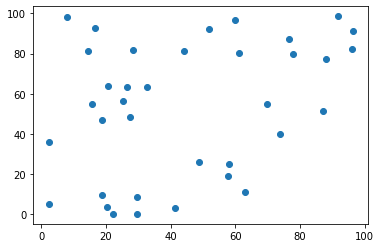

In [24]:
# assume a very simple double integrator dynamics, dx=Ax+Bu, x = [x,dx,y,dy]
dt = 0.2
A = np.array([[1, dt, 0, 0],
              [0, 1, 0, 0], 
              [0, 0, 1, dt], 
              [0, 0, 0, 1]])
B = np.array([[0, 0],
              [dt, 0],
              [0, 0],
              [0, dt]])
# assume some random initial position
num_agent = 36
m,n = B.shape
px_init = np.random.rand(num_agent)*100
py_init = np.random.rand(num_agent)*100
# px_init = np.concatenate((np.linspace(100,0,18,endpoint=True),np.linspace(0,100,18,endpoint=True)))
# py_init = np.concatenate((100*np.ones(18),np.zeros(18)))
x_init = np.zeros((m,num_agent))
x_init[0] = px_init
x_init[2] = py_init
priority = np.arange(num_agent)
np.random.shuffle(priority)
plt.scatter(px_init,py_init)
plt.show()

In [25]:
def Decentralized_CP(A,B,x_init,x_fin,Umax,Vmax,T,dt,R_col,x_nom,x_neigbs_p,collision_check):
    m, n = B.shape
    G = np.array([
        [1,0,0,0],
        [0,0,1,0]
    ])
    H = np.array([
        [0,1,0,0],
        [0,0,0,1]
    ])
    x = cp.Variable((T,m))
    u = cp.Variable((T-1,n))
    objective = cp.Minimize(cp.sum(cp.norm(u,axis=1))*dt)
    constraints = [ x[0] == x_init, x[T-1] == x_fin ]
    for k in range(T-1):
        constraints.append( x[k+1] == A@x[k] + B@u[k] )
        constraints.append( cp.norm(u[k]) <= Umax )
        constraints.append( cp.norm(H@x[k+1]) <= Vmax)
        if len(x_neigbs_p) != 0 and collision_check:
            for x_neigb in x_neigbs_p:
                x_neigb = x_neigb.T
#                 print(R_col*np.linalg.norm(x_nom[k]-x_neigb[k]))
#                 print(G@(x_nom[k]-x_neigb[k]))
                constraints.append( (x_nom[k]-x_neigb[k]).T@G.T@G@(x[k]-x_neigb[k]) >= R_col*cp.norm(G@(x_nom[k]-x_neigb[k])) )
    
    prob = cp.Problem(objective,constraints)
    prob.solve()
    return x.value, u.value, prob.value, prob.status
    
def compute_laplacian(x,R_com):
    _, num_agent = x.shape
    L = np.zeros((num_agent,num_agent))
    px, py = x[0].reshape(1,-1), x[2].reshape(1,-1)
    dist = np.sqrt((px-px.T)**2+(py-py.T)**2)
    L[dist <= R_com] = 1
    L -= np.diag(np.ones((num_agent)))
    return L


def communicate_traj(L,priority,K,x_nom):
    communication = {}
    for agent_i in K:
        communication[agent_i] = []
        for agent_j in K:
            if L[agent_i,agent_j] == 1 and priority[agent_i] < priority[agent_j]: 
                communication[agent_i].append(x_nom[agent_j,:,:])
    return communication

def check_collision(L,prioprity,x_i,x_nom,agent_i,K,R_col):
    is_collision = []
    for agent_j in K:
            if L[agent_i,agent_j] == 1 and priority[agent_i] < priority[agent_j]:
                px_i = x_i[0]
                py_i = x_i[2]
                px_j = x_nom[agent_j][0]
                py_j = x_nom[agent_j][2]
                is_collision.append(np.linalg.norm((px_i-px_j,py_i-py_j),axis=0))
    return np.all(np.array(is_collision) > R_col)

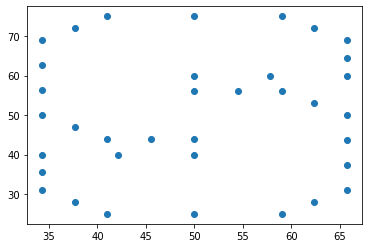

In [26]:
## Temporary
p_fin = np.loadtxt('S_uniform.txt',delimiter='\t')
T = 100
px_fin = p_fin[:,0]+34.29
py_fin = p_fin[:,1]+25
# px_fin = np.random.rand(num_agent)*100
# py_fin = np.random.rand(num_agent)*100
x_fin = np.zeros((m,num_agent))
x_fin[0] = px_fin
x_fin[2] = py_fin
Umax = 5
R_col = 2
R_com = 10
Vmax = 10
plt.scatter(px_fin,py_fin)

In [27]:
def Swarm_SCP(A,B,num_agent,x_init,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,collision_check):
    m,n = B.shape
    eps = 1e-3
    K = np.arange(num_agent).tolist()
    K_const = np.copy(K)
    x_nom = np.zeros((num_agent,m,T))
    u_nom = np.zeros((num_agent,n,T-1))
    all_cost = np.zeros((num_agent,T-1))
    x_neigbs_p = []
    for agent in K:
        x_agent, u_agent, _, _ = Decentralized_CP(A,B,x_init[:,agent],x_fin[:,agent],Umax,Vmax,T,dt,R_col,
                                               x_nom[agent].T,x_neigbs_p,collision_check)
        x_nom[agent] = x_agent.T

    L = compute_laplacian(x_init,R_com)
    neigbs_p_all = communicate_traj(L,priority,K,x_nom)
    w = 0
    while len(K) != 0:
        print(w)
        for agent in K:
            x_nom_prev = np.copy(x_nom)
            x_neigbs_p = neigbs_p_all[agent]
            x_agent, u_agent, cost, status = Decentralized_CP(A,B,x_init[:,agent],x_fin[:,agent],Umax,Vmax,T,dt,
                                                      R_col,x_nom[agent].T,x_neigbs_p,collision_check)
            if status == 'infeasible':
                return x_nom, u_nom, all_cost, status
            x_nom[agent] = x_agent.T
            u_nom[agent] = u_agent.T
            all_cost[agent] = cost
    #     L = compute_laplacian(x_init,R_com)
        neigbs_p_all = communicate_traj(L,priority,K_const,x_nom)
        K_list = np.copy(K)
        K_list = K_list.tolist()
        for agent in K:
#             print(np.linalg.norm(x_nom[agent]-x_nom_prev[agent],np.inf))
            if np.linalg.norm(x_nom[agent]-x_nom_prev[agent],np.inf) < eps and \
            check_collision(L,priority,x_nom[agent],x_nom,agent,K_const,R_col):
                K_list.remove(agent)
        w += 1
        K = np.copy(K_list)
        K = K.tolist()
    return x_nom, u_nom, all_cost, status

0
infeasible


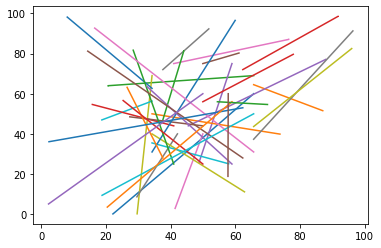

In [28]:
x_nom,u_nom,all_cost, status = Swarm_SCP(A,B,num_agent,x_init,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,True)
print(status)
# for i in range(T):
#     plt.scatter(x_nom[:,0,i],x_nom[:,2,i])
    
for i in range(num_agent):
    plt.plot(x_nom[i,0,:],x_nom[i,2,:])
    

In [29]:
print(x_nom.T.shape)
np.savetxt('infeasible.txt',x_nom.T.reshape(100,-1),delimiter='\t')

(100, 4, 36)


In [378]:
k0 = 0
x = x_init
all_x = [x]
all_u = []
eps = 1e-3
while True:
    x_nom, u_nom, all_cost, status = Swarm_SCP(A,B,num_agent,x,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,True)
    if status == 'infeasible': 
        print('Problem Infeasible!') 
        break
    x = A@x+B@u_nom[:,:,0].T
    all_x.append(x)
    all_u.append(u_nom[:,:,0].T)
    if np.all(x-x_fin <= eps): break
    T -= 1
    print(T)
    if T == 0: raise Exception("Planning horizon not long enough")

0
119
0
118
0
117
0
116
0
115
0
114
0
113
0
112
0
111
0
110
0
109
0
108
0
Problem Infeasible!


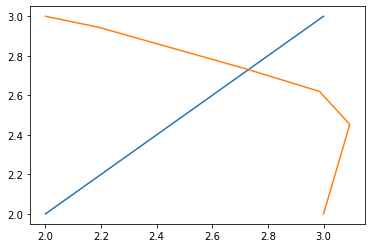

In [342]:
x = np.array(all_x)
for i in range(num_agent):
    plt.plot(x[:,0,i],x[:,2,i])

In [278]:
np.savetxt('cross.txt',x.reshape(10,-1),delimiter='\t')

In [23]:
data = []

In [21]:
## Disturbance modeling
def downwash(dx,dy,sigma):
    x_dist = -1/(sigma*np.sqrt(2*np.pi))*np.exp(-(dx/sigma)**2/2)
    y_dist = max(0,6.5-dy/(1*sigma))
    return x_dist*y_dist
    

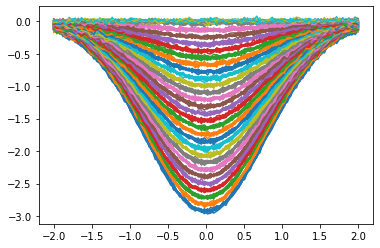

In [39]:
for i in range(10):
    all_x = []
    all_y = np.linspace(0.5,5.5,30)
    for dy in all_y:
        x = []
        for dx in np.linspace(-2,2,100):
            x.append(downwash(dx,dy,0.8))
        all_x.append(x)
    acc = []
    for i in range(len(all_x)):
        plt.plot(np.linspace(-2,2,100),all_x[i]+2e-2*np.random.normal(0,1,len(all_x[i])))
        acc.append(all_x[i]+5e-3*np.random.normal(0,1,len(all_x[i])))
    dx = np.array([np.linspace(-2,2,100)]*30).reshape(-1,1)
    dy = np.multiply(np.ones((100,30)),all_y).T.reshape(-1,1)
    acc = np.array(acc).reshape(-1,1)
    data.append(np.concatenate((dx,dy,acc),axis=1))

In [305]:
np.array([np.linspace(-2,2,100)]*30).shape

(30, 100)

In [188]:
dx.shape

(3000, 1)

In [189]:
dy.shape

(3000, 1)

In [190]:
acc.shape

(3000, 1)

In [191]:
np.concatenate((dx,dy,acc),axis=1)

array([[-0.02136262,  0.1       , -0.11946744],
       [-0.02420671,  0.1       , -0.12277345],
       [-0.02735957,  0.1       , -0.13106293],
       ...,
       [-0.        ,  1.        , -1.00009498],
       [-0.        ,  1.        , -1.00192336],
       [-0.        ,  1.        , -0.99598547]])

In [310]:
np.concatenate(np.array(data),axis=0).shape

(30000, 3)

In [8]:
np.savetxt('data.txt',np.concatenate(np.array(data),axis=0),delimiter='\t')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPool2D,Dropout,Flatten
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.initializers import glorot_uniform
import os
from matplotlib import pyplot as plt

nnet = load_model('my_model_2.h5')

2022-03-04 11:40:55.847817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


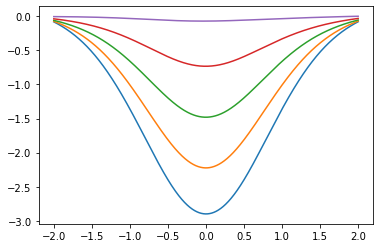

In [7]:
N = 1000
dx = np.linspace(-2, 2, N).reshape([-1, 1])
dy = np.linspace(0.5,5.2,5,endpoint=True)
data = []
for y in dy:
    data_in = np.concatenate((dx, y*np.ones(N).reshape([-1,1])), axis = 1)

    data_out = nnet.predict(data_in)*2.935402561181967**2
    plt.plot(dx, data_out)
    data.append(data_out)


In [3]:
?np.linspace

In [ ]:
k0 = 0
x = x_init
all_x = [x]
all_u = []
eps = 1e-3
while True:
    x_nom, u_nom, all_cost, status = Swarm_SCP(A,B,num_agent,x,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,True)
    if status == 'infeasible': 
        print('Problem Infeasible!') 
        break
    
    x = A@x+B@(u_nom[:,:,0].T+2.935402561181967*2*nnet.predict()
    all_x.append(x)
    all_u.append(u_nom[:,:,0].T)
    if np.all(x-x_fin <= eps): break
    T -= 1
    print(T)
    if T == 0: raise Exception("Planning horizon not long enough")